In [ ]:
!dir
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import skimage
from skimage.color import rgb2gray
from skimage.morphology import rectangle as rect , disk , square

from skimage.morphology import(binary_erosion, 
                               binary_dilation,
                               binary_closing,
                               binary_opening,
                               skeletonize,
                               thin
                              )
from skimage.measure import find_contours

from skimage.draw import rectangle
from skimage.draw import rectangle_perimeter
from skimage.filters import threshold_otsu



from skimage.transform import hough_line, hough_line_peaks , hough_circle, hough_circle_peaks , hough_ellipse
from skimage.draw import circle_perimeter , ellipse_perimeter
from skimage.feature import canny
from skimage.util import img_as_ubyte


In [2]:
# common functions

def get_bounding_boxes(img,box_aspect_ratio):
    """
    summary: this function returns
    parameter:
    img: is a binary image for which to find the contours 
    aspect_ratio: is a tuple where (low_aspect_ratio,high_aspect_ratio)
    """
    contours = find_contours(img,.8)
    bounding_boxes=[]
    for contour in contours:
        Xmin= np.min(contour[:,1])
        Xmax=np.max(contour[:,1]) 
        Ymin=np.min(contour[:,0])
        Ymax = np.max(contour[:,0])
        aspect_ratio = (Xmax-Xmin)/(Ymax-Ymin)
    #     aspect_ratio=1/aspect_ratio
        if aspect_ratio >= box_aspect_ratio[0] and aspect_ratio <= box_aspect_ratio[1]:
            bounding_boxes.append([Xmin,Xmax,Ymin,Ymax])
        
    return bounding_boxes
def get_bounded_image(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    return img2
def draw_bounding_boxes(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    show_images([conte,img2], ['bounding_boxes','original segmented'])
    
# Used to Detect Filled Notes (Quarter , 8th , 16th , 32th)
# Detects Quarter only with further processing to detect other types

def detect_filled(img,opening_radius,closing_radius):
    
    selem = disk(opening_radius)
    opened_image = binary_opening(img,selem)
    
    selem = disk(closing_radius)
    Type_Quarter = binary_dilation(opened_image,selem)
    
    return Type_Quarter

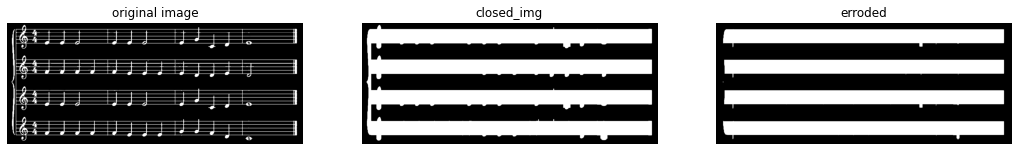

In [3]:
original_image = io.imread('images/music1.JPG')
gray_image = rgb2gray(original_image)
binary_image = binarize(gray_image)
inverted_image = 255 - binary_image
rows=17
cols=20
selem = rect(rows,cols)
closed_img = binary_closing(inverted_image,selem=selem)

selem = rect(3,20)
erroded_img = binary_erosion(closed_img,selem=selem)
show_images([inverted_image,closed_img,erroded_img],['original image','closed_img','erroded'])

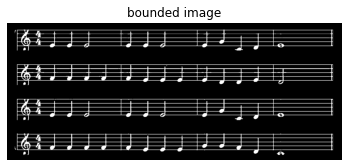

In [4]:
## let's find the contours
#When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
# print(bounding_boxes)
bounding_boxes = get_bounding_boxes(erroded_img,(4,4000))
# draw_bounding_boxes(inverted_image,bounding_boxes)
bounded_image = get_bounded_image(inverted_image, bounding_boxes)
show_images([bounded_image],['bounded image'])

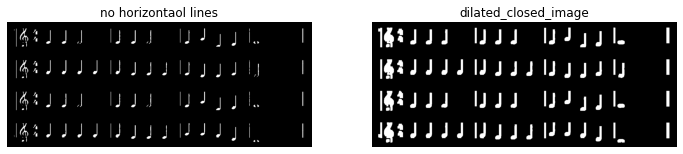

In [5]:
# let's remove thin horizontal lines
rows=5
cols=1
selem = rect(rows,cols)
no_horiz_line_image = binary_erosion(bounded_image,selem=selem)
rows=10
cols=10
selem = rect(rows,cols)
dilated_closed_image = binary_dilation(binary_closing(no_horiz_line_image,selem=selem),selem=selem)
dilated_closed_image = binary_erosion(dilated_closed_image, rect(3,3))
show_images([no_horiz_line_image,dilated_closed_image],['no horizontaol lines','dilated_closed_image'])


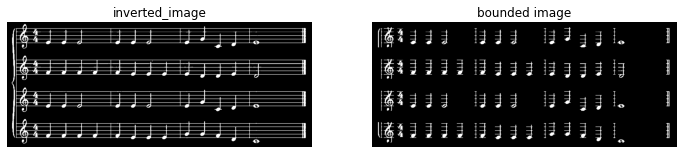

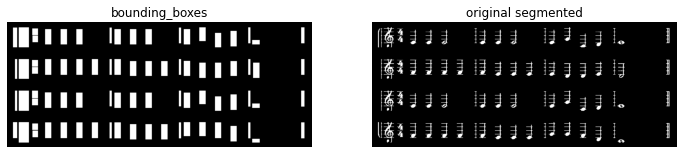

In [6]:
# let's get the bounding boxes for the individual symbols
bounding_boxes = get_bounding_boxes(dilated_closed_image,(0,4000))
# draw_bounding_boxes(inverted_image,bounding_boxes)
bounded_image = get_bounded_image(inverted_image, bounding_boxes)
show_images([inverted_image,bounded_image],['inverted_image','bounded image'])
draw_bounding_boxes(bounded_image,bounding_boxes)

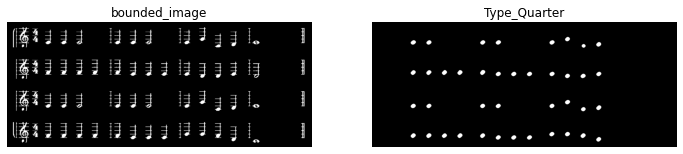

In [7]:
# Detect Quarter 

opening_radius = 6
closing_radius = 2

Type_Quarter = detect_filled( bounded_image , opening_radius , closing_radius )
show_images([bounded_image,Type_Quarter],['bounded_image','Type_Quarter'])

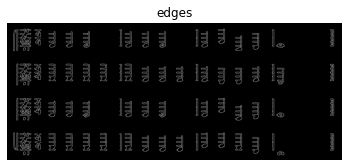

In [10]:
# Detect Whole & Half
# Edge Detection then Hough Ellipse Transform
image_gray = bounded_image
edges = canny(image_gray, sigma=2.0)

show_images([edges],['edges'])

In [27]:
# Detect circles in the image
print("Start Hough circle")
try_radii = np.arange(30, 42, 1)
print(try_radii)
resultCircle = hough_circle(edges, try_radii) # accumulator matrix
print(resultCircle.shape)

Start Hough circle
[30 31 32 33 34 35 36 37 38 39 40 41]
(12, 563, 1377)


In [ ]:
for radius, h in zip(try_radii, hough_res):
    peaks = peak_local_max(h, num_peaks=2)
    centers.extend(peaks - hough_radii.max())
    accums.extend(h[peaks[:, 0], peaks[:, 1]])
    radii.extend([radius, radius])

image = color.gray2rgb(image)
for idx in np.argsort(accums)[::-1][:5]:
    center_x, center_y = centers[idx]
    radius = radii[idx]
    cx, cy = circle_perimeter(center_y, center_x, radius)
    image[cy, cx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

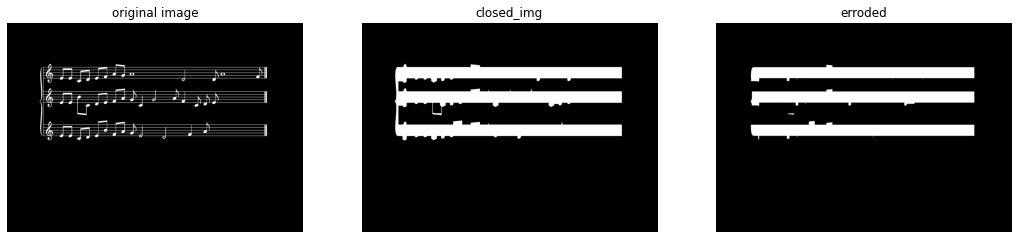

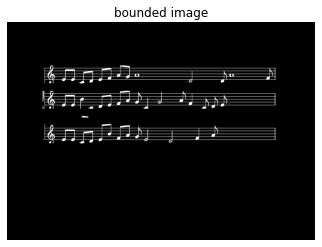

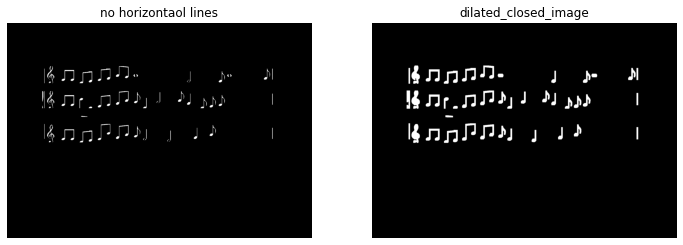

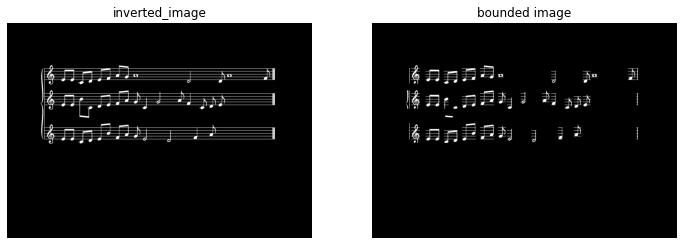

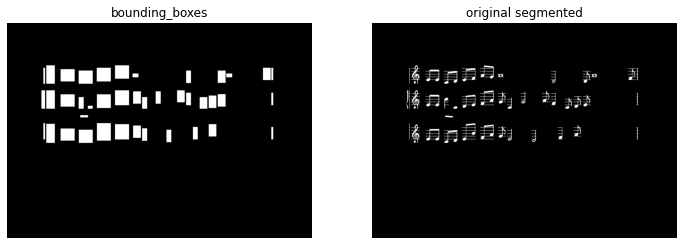

In [28]:
# Work on 8 Notes

original_image = io.imread('images/8_sheet_001.jpg')
gray_image = rgb2gray(original_image)
binary_image = binarize(gray_image)
inverted_image = 255 - binary_image
rows=20
cols=25
selem = rect(rows,cols)
closed_img = binary_closing(inverted_image,selem=selem)

selem = rect(3,20)
erroded_img = binary_erosion(closed_img,selem=selem)
show_images([inverted_image,closed_img,erroded_img],['original image','closed_img','erroded'])

bounding_boxes = get_bounding_boxes(erroded_img,(4,4000))
bounded_image = get_bounded_image(inverted_image, bounding_boxes)
show_images([bounded_image],['bounded image'])

rows=5
cols=1
selem = rect(rows,cols)
no_horiz_line_image = binary_erosion(bounded_image,selem=selem)
rows=10
cols=10
selem = rect(rows,cols)
dilated_closed_image = binary_dilation(binary_closing(no_horiz_line_image,selem=selem),selem=selem)
dilated_closed_image = binary_erosion(dilated_closed_image, rect(3,3))
show_images([no_horiz_line_image,dilated_closed_image],['no horizontaol lines','dilated_closed_image'])

bounding_boxes = get_bounding_boxes(dilated_closed_image,(0,4000))
bounded_image = get_bounded_image(inverted_image, bounding_boxes)
show_images([inverted_image,bounded_image],['inverted_image','bounded image'])
draw_bounding_boxes(bounded_image,bounding_boxes)


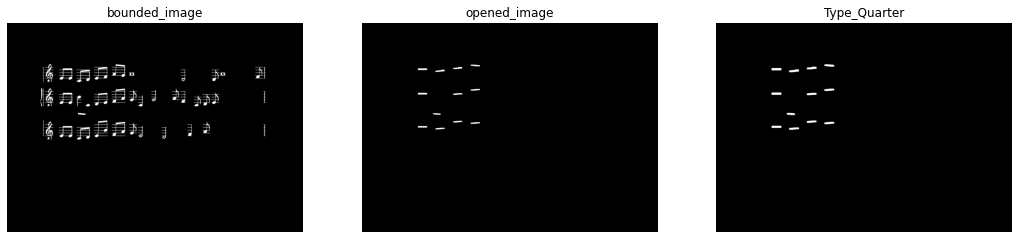

In [45]:
selem = rect(5,20)
opened_image = binary_opening(bounded_image,selem)
Note8th_Beaming = binary_dilation(opened_image,selem)

show_images([bounded_image,opened_image,Type_Quarter],['bounded_image','opened_image','Beaming'])